#### Declarations and definitions

In [1]:
import numpy as np
import gensim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
import glob
import os
import datetime
from pathlib import Path
from gensim.models.doc2vec import TaggedDocument
from gensim.models.word2vec import Word2Vec
from collections import namedtuple
from sklearn.externals import joblib
import statistics
import random

homePath = str(Path.home()) + "/MLClassificationData"
# Path to tokenized corpus for training
trainRoot = homePath + '/train/rtanews/target'
# Path to tokenized corpus for testing
testRoot = homePath + '/test/rtanews/target'
# Path to saved models
modelPath = homePath + '/models'
modelId = 2
nCats = 0
n_dim = 100
categories = dict()

LabeledDocument = namedtuple('LabeledDocument', 'lines words labels nlabs qLabs')

def getCategories(path):
    cats = dict()
    nCats = 0
    os.chdir(path)
    for f in glob.glob("*"):
        if os.path.isdir(f):
            cats[f] = nCats
            nCats += 1
    return cats

def prepareDocsData(path, cats):
    files = dict()
    fInCats = [0] * len(cats)
    nFiles = 0
    actFiles = 0
    curCategory = 0
    docs = []
    os.chdir(path)
    rootDir = os.getcwd()
    for f in glob.glob("*"):
        curCategory = cats[f]
        catPath = path + "/" + f
        os.chdir(catPath)
        for fc in glob.glob("*"):
            actFiles += 1
            if fc not in files:
                nFiles += 1
                fPath = catPath + "/" + fc
                docCont = ''
                with open(fc, 'r', encoding='UTF-8') as tc:
                    for line in tc:
                        docCont += line.strip() + " "
                tc.close()
                words = docCont.strip().split() 
                labels = [0] * len(cats)
                labels[curCategory] = 1
                nlabs = [f]
                files[fc] = LabeledDocument(docCont.strip(), words, labels, nlabs, [1])
            else:
                files[fc].labels[curCategory] = 1
                files[fc].nlabs.append(f)
                files[fc].qLabs[0] += 1
            fInCats[curCategory] += 1
    kk = 0
    for k, val in files.items():
        docs.append(val)
    return docs, fInCats

def getLabelSets(docs):
    labels = [x[2] for x in docs]
    results = [labels[0]]
    qLabs = 0
    for i in range(len(labels)):        
        if i%1000 == 0:
            print (str(i), end='\r')
        qLabs += sum(labels[i])
        count = 0
        for j in range(len(results)):
            for k in range(len(categories)):
                if labels[i][k] != results[j][k]:
                    count += 1
                    break
        if count == len(results):
            results.append(labels[i])
    return len(results), qLabs
    
def showTime(ds,de):
    result = ''
    seconds = (de-ds).total_seconds()
    if seconds < 1:
        return "less than 1 sec"
    hh = int(seconds/(60*60));
    if hh > 0:
        result = "%d h:"%(hh);
    seconds -= hh*60*60
    mm = int(seconds/60);
    if mm > 0:
        result += "%d min:"%(mm)
    ss = seconds - mm*60;
    result += "%d sec"%(ss)
    return result

def showDocsByLength(plt):
    fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10,6))    
    dictLens = dict()
    dictLens1 = dict()
    for i in range(len(trainDocs)):
        lend = "%5d"%(len(trainDocs[i].words))
        if not lend in dictLens:
            dictLens[lend] = 1
        else:
            dictLens[lend] += 1
    lens = sorted(list(dictLens.items()))
    lvars = [int(x[0]) for x in lens]
    locc = [x[1] for x in lens]
    plot1.set_title ("Documents by tokens in training set")
    plot1.set_ylabel("Documents")
    plot1.set_xlabel("Tokens")
    plot1.plot(lvars, locc, "b.-") 
    for i in range(len(testDocs)):
        lend = "%5d"%(len(testDocs[i].words))
        if not lend in dictLens1:
            dictLens1[lend] = 1
        else:
            dictLens1[lend] += 1
    lens1 = sorted(list(dictLens1.items()))
    lvars1 = [int(x[0]) for x in lens1]
    locc1 = [x[1] for x in lens1]
    plot2.set_title ("Documents by tokens in testing set")
    #plot2.set_ylabel("Documents")
    plot2.set_xlabel("Tokens")
    plot2.yaxis.tick_right()
    plot2.plot(lvars1, locc1, "b.-") 
    plt.show()
    
def showDocsByLabs(plt):
    fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10,6))
    dictLabs = dict()
    dictLabs1 = dict()
    for i in range(len(trainDocs)):
        lab = "%5d"%(trainDocs[i].qLabs[0])
        if not lab in dictLabs:
            dictLabs[lab] = 1
        else:
            dictLabs[lab] += 1
    labs = sorted(list(dictLabs.items()))
    lvars1 = [int(x[0]) for x in labs]
    locc1 = [x[1] for x in labs]
    plot1.set_title ("Documents by labels in training set")
    plot1.set_ylabel("Documents")
    plot1.set_xlabel("Labels")
    plot1.set_xticks(np.arange(0, len(categories), step=1))
    plot1.plot(lvars1, locc1, "bo-")
    for i in range(len(testDocs)):
        lab = "%5d"%(testDocs[i].qLabs[0])
        if not lab in dictLabs1:
            dictLabs1[lab] = 1
        else:
            dictLabs1[lab] += 1
    labs1 = sorted(list(dictLabs1.items()))
    lvars2 = [int(x[0]) for x in labs1]
    locc2 = [x[1] for x in labs1]
    plot2.set_title ("Documents by labels in testing set")
    #plot2.set_ylabel("Documents")
    plot2.set_xlabel("Labels")
    plot2.set_xticks(np.arange(0, len(categories), step=1))
    plot2.yaxis.tick_right()
    plot2.plot(lvars2, locc2, "bo-")
    plt.show()

#### Calculate metrics

In [2]:
def rankIndicator(test, result, index):
    actual = False
    predicted = False
    if result[index] == 1:
        predicted = True
    if test[index] == 1:
        actual = True
    return actual, predicted

def getMetrics(test_labels, res, categories, rank):
    # General results   
    tp = 0
    fp = 0
    fn = 0
    tagged = 0
    predicted = 0
    for i in range(len(y_test)):
        for j in range(len(categories)):
            if prediction[i][j] == 1:
                predicted += 1
                if y_test[i][j] == 1:
                    tagged += 1
                    tp += 1
                else:
                    fp += 1
            else:
                if y_test[i][j] == 1:
                    tagged += 1
                    fn += 1
    print ("Labels actual: %d, predicted: %d, correctly: %d, incorrectly: %d, not predicted: %d"%(tagged, predicted, tp, fp, fn))
    print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

    #Exact Match Ratio
    wrongPreds = 0
    for i in range(len(test_labels)):
        for j in range(len(categories)):
            actual, predicted = rankIndicator(test_labels[i], res[i], j)
            if (actual and not predicted) or (predicted and not actual):
                wrongPreds += 1
                break;
    print ("Exact Match Ratio:  %.2f%%" % ((len(test_labels) - wrongPreds)/len(test_labels) * 100))

    #Accuracy
    accuracy = 0.
    for i in range(len(test_labels)):
        labels = sum(test_labels[i])
        tp = 0
        tfp = 0
        for j in range(len(categories)):
            actual, predicted = rankIndicator(test_labels[i], res[i], j)
            if actual and predicted:
                tp += 1
            if predicted and not actual:
                tfp += 1
        accuracy += tp / (labels + tfp)
    print ("Accuracy:  %.2f%%" % (accuracy / len(test_labels) * 100))  

    #Precision
    precision = 0.
    for i in range(len(test_labels)):
        labels = sum(test_labels[i])
        tp = 0
        tfp = 0
        for j in range(len(categories)):
            actual, predicted = rankIndicator(test_labels[i], res[i], j)
            if actual and predicted:
                tp += 1
        precision += tp / labels
    print ("Precision:  %.2f%%" % (precision / len(test_labels) * 100))  

    #Recall
    recall = 0.
    for i in range(len(test_labels)):
        labels = sum(test_labels[i])
        tp = 0
        tfp = 0
        for j in range(len(categories)):
            actual, predicted = rankIndicator(test_labels[i], res[i], j)
            if actual and predicted:
                tp += 1
            if predicted:
                tfp += 1
        if tfp > 0:
            recall += tp / tfp
    print ("Recall:  %.2f%%" % (recall / len(test_labels) * 100))  

    #F1-Measure
    f1 = 0.
    for i in range(len(test_labels)):
        labels = sum(test_labels[i])
        tp = 0
        tfp = 0
        for j in range(len(categories)):
            actual, predicted = rankIndicator(test_labels[i], res[i], j)
            if actual and predicted:
                tp += 1
            if predicted:
                tfp += 1
        f1 += 2 * tp / (tfp + labels)
    print ("F1-Measure:  %.2f%%" % (f1 / len(test_labels) * 100))

    #Hamming Loss
    hl = 0.
    for i in range(len(test_labels)):
        labels = sum(test_labels[i])
        for j in range(len(categories)):
            actual, predicted = rankIndicator(test_labels[i], res[i], j)
            if (actual and not predicted) or (predicted and not actual):
                hl += 1
    print ("Hamming Loss:  %.2f%%" % (hl * 100 / (len(test_labels) * len(categories)))) 

    #Macro-Averaged Precision
    precision = 0
    for i in range(len(categories)):
        tp = 0
        tact = 0
        for j in range(len(test_labels)):
            actual, predicted = rankIndicator(test_labels[j], res[j], i) 
            if not actual:
                continue
            tact += 1
            if predicted:
                tp += 1
        precision += tp / tact
    print ("Macro-Averaged Precision:  %.2f%%" % (precision / len(categories) * 100))  

    #Macro-Averaged Recall
    recall = 0
    for i in range(len(categories)):
        tp = 0
        tact = 0
        for j in range(len(test_labels)):
            actual, predicted = rankIndicator(test_labels[j], res[j], i)
            if predicted:
                tact += 1
                if actual:
                    tp += 1
        recall += tp / tact
    print ("Macro-Averaged Recall:  %.2f%%" % (recall / len(categories) * 100))  

    #Macro-Averaged F1-Measure
    f1 = 0
    for i in range(len(categories)):
        tp = 0
        tact = 0
        labs = 0
        for j in range(len(test_labels)):
            actual, predicted = rankIndicator(test_labels[j], res[j], i)
            if actual:
                labs += 1
            if predicted:
                tact += 1
                if actual:
                    tp += 1
        f1 += 2 * tp / (tact + labs)
    print ("Macro-Averaged F1-Measure:  %.2f%%" % (f1 / len(categories) * 100))  

    #Micro-Averaged Precision
    precision = 0
    tp = 0
    tact = 0
    for i in range(len(categories)):
        for j in range(len(test_labels)):
            actual, predicted = rankIndicator(test_labels[j], res[j], i) 
            if not actual:
                continue
            tact += 1
            if predicted:
                tp += 1
    precision += tp / tact
    print ("Micro-Averaged Precision:  %.2f%%" % (precision * 100))  

    #Micro-Averaged Recall
    recall = 0
    tp = 0
    tact = 0
    for i in range(len(categories)):
        for j in range(len(test_labels)):
            actual, predicted = rankIndicator(test_labels[j], res[j], i)
            if predicted:
                tact += 1
                if actual:
                    tp += 1
    recall += tp / tact
    print ("Micro-Averaged Recall:  %.2f%%" % (recall * 100))  

    #Micro-Averaged F1-Measure
    f1 = 0
    tp = 0
    tact = 0
    labs = 0
    for i in range(len(categories)):
        for j in range(len(test_labels)):
            actual, predicted = rankIndicator(test_labels[j], res[j], i)
            if actual:
                labs += 1
            if predicted:
                tact += 1
                if actual:
                    tp += 1
    f1 += 2 * tp / (tact + labs)
    print ("Micro-Averaged F1-Measure:  %.2f%%" % (f1 * 100))  

    if not rank:
        return
    
    #One error
    o_err = 0
    for i in range(len(test_labels)):
        list = [(0,0) for i in range(len(categories))]
        for j in range(len(categories)):
            list[j] = (test_labels[i][j], res[i][j])
        list.sort(key=getPrediction, reverse=True)
        if list[0][0] == 0:
            o_err += 1
    print ("One Error: %.2f%%" % (o_err / len(test_labels) * 100))

    #Coverage
    stepsDown = 0
    for i in range(len(test_labels)):
        bound = sum(test_labels[i]) - 1
        list = [(0,0,0) for i in range(len(categories))]
        for j in range(len(categories)):
            list[j] = (test_labels[i][j], res[i][j], j)
        list.sort(key=getPrediction, reverse=True)
        eSteps = 0
        for j in range(len(categories)):
            if test_labels[i][j] == 0:
                continue
            for k in range(len(list)):
                if list[k][2] == j:
                    eSteps = max(eSteps, k)
        stepsDown += max(0, eSteps - bound)
    print ("Coverage: %.2f" % (stepsDown / len(test_labels))) 

    #Ranking Loss
    rl = 0
    for i in range(len(test_labels)):
        mult = sum(test_labels[i])
        list = [(0,0) for i in range(len(categories))]
        wrongOrder = 0
        for j in range(len(categories)):
            list[j] = (test_labels[i][j], res[i][j])
        list.sort(key=getPrediction, reverse=True)
        for j in range(len(list)):
            if list[j][0] == 1:
                mult -= 1
                if mult == 0:
                    break
                continue
            wrongOrder += mult
        rl += wrongOrder / sum(test_labels[i])
    print ("Ranking Loss: %.2f" % (rl / len(test_labels)))    

#### Load input data

In [3]:
ds = datetime.datetime.now()
categories = getCategories(trainRoot)
trainDocs, fInCats1 = prepareDocsData(trainRoot, categories)
trainDocs = random.sample(trainDocs, len(trainDocs))
testDocs, fInCats2 = prepareDocsData(testRoot, categories)
testDocs = random.sample(testDocs, len(testDocs))
maxDocLen = max(len(x.words) for x in trainDocs)
minDocLen = min(len(x.words) for x in trainDocs)
avrgDocLen = round(statistics.mean(len(x.words) for x in trainDocs), 2)
de = datetime.datetime.now()
print ("Load input data in %s"%(showTime(ds, de))) 

Load input data in 3 sec


#### Dataset analisys

Dataset properties:
Loaded 23837 documents: 15001 for training, 8836 for test
Tokens in documents: maximum: 1330, minimum: 46, average: 170


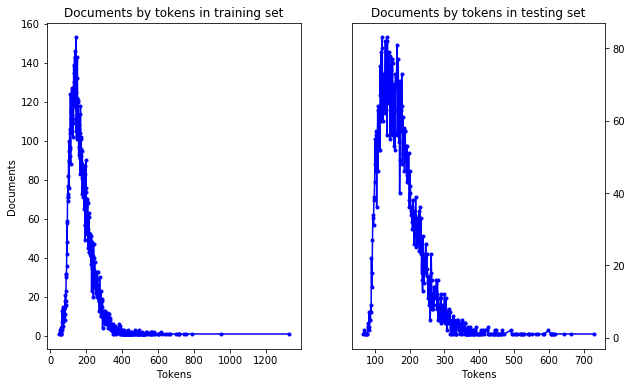

Categories: 40
Documents for training in category : maximum: 2800, minimum: 93, avegare: 415
Documents for testing  in category : maximum: 1501, minimum: 65, avegare: 276


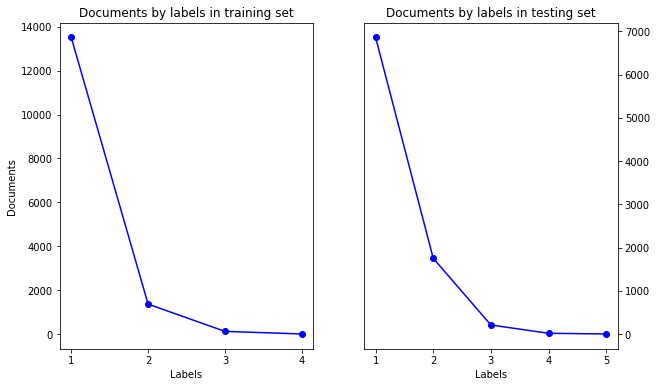

Distinct Label Set: 290
Proportion of Distinct Label Set: 0.0193
Label Cardinality: 1.1073
Label Density: 0.0277


In [4]:
print ("Dataset properties:")
dls, qLabs = getLabelSets(trainDocs)
print ('Loaded %d documents: %d for training, %d for test' % (len(trainDocs) + len(testDocs), len(trainDocs), len(testDocs)))
print ("Tokens in documents: maximum: %d, minimum: %d, average: %d"%(maxDocLen, minDocLen, avrgDocLen))
showDocsByLength(plt)
print ("Categories: %d"%(len(categories)))
print ("Documents for training in category : maximum: %d, minimum: %d, avegare: %d"%(max(fInCats1), min(fInCats1), round(statistics.mean(fInCats1), 2)))
print ("Documents for testing  in category : maximum: %d, minimum: %d, avegare: %d"%(max(fInCats2), min(fInCats2), round(statistics.mean(fInCats2), 2)))
showDocsByLabs(plt)
print ("Distinct Label Set: %d"%(dls))
print ("Proportion of Distinct Label Set: %.4f"%(dls/len(trainDocs)))
print ("Label Cardinality: %.4f"%(qLabs/len(trainDocs)))
print ("Label Density: %.4f"%(qLabs/len(trainDocs)/len(categories)))

#### Prepare input for training and testing

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

print ("Prepare data...", end='\r')
ds = datetime.datetime.now()
nmCats = [""] * len(categories)
cKeys = list(categories.keys())
for i in range(len(cKeys)):
    nmCats[categories[cKeys[i]]] = cKeys[i]
    
mlb = MultiLabelBinarizer(classes = nmCats)
wev = TfidfVectorizer(ngram_range=(1,3), max_df=0.50).fit([x.lines for x in trainDocs], [x.nlabs for x in trainDocs])
X_train = wev.transform([x.lines for x in trainDocs])
y_train = mlb.fit_transform([x.nlabs for x in trainDocs])
X_test = wev.transform([x.lines for x in testDocs])
y_test = mlb.fit_transform([x.nlabs for x in testDocs])
de = datetime.datetime.now()
print ("Prepare data in %s"%(showTime(ds, de)))

Prepare data in 1 min:2 sec


#### Create model using RidgeClassifierCV

In [6]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.multiclass import OneVsRestClassifier

print ("Train...", end='\r')
clf1 = OneVsRestClassifier(RidgeClassifierCV())
de = datetime.datetime.now()
clf1.fit(X_train, y_train)
ds = datetime.datetime.now()
print ("Train in %s"%(showTime(de, ds)))

print ("Prediction...", end='\r')
prediction = clf1.predict(X_test)
de = datetime.datetime.now()
print ("Prediction in %s"%(showTime(ds, de)))
getMetrics(y_test, prediction, categories, False)

Train in 3 h:54 min:56 sec
Prediction in 1 sec
Labels actual: 11060, predicted: 8868, correctly: 7550, incorrectly: 1318, not predicted: 3510
Test accuracy is 0.6084200995925758
Exact Match Ratio:  60.84%
Accuracy:  70.34%
Precision:  73.55%
Recall:  76.93%
F1-Measure:  73.60%
Hamming Loss:  1.37%
Macro-Averaged Precision:  63.71%
Macro-Averaged Recall:  84.32%
Macro-Averaged F1-Measure:  71.18%
Micro-Averaged Precision:  68.26%
Micro-Averaged Recall:  85.14%
Micro-Averaged F1-Measure:  75.77%


#### Create model using LinearSVC

In [7]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

de = datetime.datetime.now()
print ("Train...", end='\r')
clf2 = OneVsRestClassifier(LinearSVC(multi_class='ovr'))
clf2.fit(X_train, y_train)
ds = datetime.datetime.now()
print ("Train in %s"%(showTime(de, ds)))

print ("Prediction...", end='\r')
prediction = clf2.predict(X_test)
de = datetime.datetime.now()
print ("Prediction in %s"%(showTime(ds, de)))
getMetrics(y_test, prediction, categories, False)

Train in 46 sec
Prediction in less than 1 sec
Labels actual: 11060, predicted: 8471, correctly: 7269, incorrectly: 1202, not predicted: 3791
Test accuracy is 0.5950656405613399
Exact Match Ratio:  59.51%
Accuracy:  68.47%
Precision:  71.19%
Recall:  75.06%
F1-Measure:  71.55%
Hamming Loss:  1.41%
Macro-Averaged Precision:  59.76%
Macro-Averaged Recall:  85.21%
Macro-Averaged F1-Measure:  68.23%
Micro-Averaged Precision:  65.72%
Micro-Averaged Recall:  85.81%
Micro-Averaged F1-Measure:  74.44%


#### Create model using SGDClassifier

In [8]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

de = datetime.datetime.now()
print ("Train...", end='\r')
clf3 = OneVsRestClassifier(SGDClassifier(loss='modified_huber', penalty='elasticnet', alpha=1e-4, max_iter=10, n_jobs=-1))
clf3.fit(X_train, y_train)
ds = datetime.datetime.now()
print ("Train in %s"%(showTime(de, ds)))

print ("Prediction...", end='\r')
prediction = clf3.predict(X_test)
de = datetime.datetime.now()
print ("Prediction in %s"%(showTime(ds, de)))
getMetrics(y_test, prediction, categories, False)

Train in 1 min:30 sec
Prediction in 1 sec
Labels actual: 11060, predicted: 9109, correctly: 7616, incorrectly: 1493, not predicted: 3444
Test accuracy is 0.5998189225894069
Exact Match Ratio:  59.98%
Accuracy:  70.10%
Precision:  74.05%
Recall:  76.51%
F1-Measure:  73.57%
Hamming Loss:  1.40%
Macro-Averaged Precision:  64.21%
Macro-Averaged Recall:  82.52%
Macro-Averaged F1-Measure:  70.83%
Micro-Averaged Precision:  68.86%
Micro-Averaged Recall:  83.61%
Micro-Averaged F1-Measure:  75.52%


#### Create model using Perceptron

In [10]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import Perceptron

de = datetime.datetime.now()
print ("Train...", end='\r')
clf4 = OneVsRestClassifier(Perceptron(n_jobs=-1, max_iter=20))
clf4.fit(X_train, y_train)
ds = datetime.datetime.now()
print ("Train in %s"%(showTime(de, ds)))

print ("Prediction...", end='\r')
prediction = clf4.predict(X_test)
de = datetime.datetime.now()
print ("Prediction in %s"%(showTime(ds, de)))
getMetrics(y_test, prediction, categories, False)

Train in 1 min:4 sec
Prediction in less than 1 sec
Labels actual: 11060, predicted: 10430, correctly: 8070, incorrectly: 2360, not predicted: 2990
Test accuracy is 0.590651878678135
Exact Match Ratio:  59.07%
Accuracy:  71.62%
Precision:  78.09%
Recall:  77.99%
F1-Measure:  75.95%
Hamming Loss:  1.51%
Macro-Averaged Precision:  71.56%
Macro-Averaged Recall:  73.41%
Macro-Averaged F1-Measure:  72.08%
Micro-Averaged Precision:  72.97%
Micro-Averaged Recall:  77.37%
Micro-Averaged F1-Measure:  75.10%


#### Create model using PassiveAggressiveClassifier

In [11]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

de = datetime.datetime.now()
print ("Train...", end='\r')
clf5 = OneVsRestClassifier(PassiveAggressiveClassifier(n_jobs=-1, max_iter=20))
clf5.fit(X_train, y_train)
ds = datetime.datetime.now()
print ("Train in %s"%(showTime(de, ds)))

print ("Prediction...", end='\r')
prediction = clf5.predict(X_test)
de = datetime.datetime.now()
print ("Prediction in %s"%(showTime(ds, de)))
getMetrics(y_test, prediction, categories, False)

Train in 1 min:13 sec
Prediction in less than 1 sec
Labels actual: 11060, predicted: 8895, correctly: 7608, incorrectly: 1287, not predicted: 3452
Test accuracy is 0.6156631960162969
Exact Match Ratio:  61.57%
Accuracy:  71.08%
Precision:  74.13%
Recall:  77.78%
F1-Measure:  74.33%
Hamming Loss:  1.34%
Macro-Averaged Precision:  64.72%
Macro-Averaged Recall:  84.73%
Macro-Averaged F1-Measure:  71.92%
Micro-Averaged Precision:  68.79%
Micro-Averaged Recall:  85.53%
Micro-Averaged F1-Measure:  76.25%


#### Save choosen model

In [12]:
#Choose one of the models above
model = clf5
modelId = 2
modelName = "model%d-%s"%(modelId, datetime.datetime.now().strftime("%Y-%b-%d-%H%M%S"))
path = modelPath + "/" + modelName
joblib.dump(model, path)

['/home/user/MLClassificationData/models/model2-2018-Nov-18-212022']

#### Reload model

In [13]:
model = joblib.load(path)
print ("Prediction...", end='\r')
prediction = model.predict(X_test)
getMetrics(y_test, prediction, categories, False)

Labels actual: 11060, predicted: 8895, correctly: 7608, incorrectly: 1287, not predicted: 3452
Test accuracy is 0.6156631960162969
Exact Match Ratio:  61.57%
Accuracy:  71.08%
Precision:  74.13%
Recall:  77.78%
F1-Measure:  74.33%
Hamming Loss:  1.34%
Macro-Averaged Precision:  64.72%
Macro-Averaged Recall:  84.73%
Macro-Averaged F1-Measure:  71.92%
Micro-Averaged Precision:  68.79%
Micro-Averaged Recall:  85.53%
Micro-Averaged F1-Measure:  76.25%
